# Data Verification

INFO:sensors.spindle_applied:Writing: AX
INFO:sensors.spindle_applied:Writing: ME
INFO:sensors.spindle_applied:Writing: IFD
INFO:sensors.spindle_applied:Initalized Applied Motion Spindle
INFO:sensors.spindle_applied:Writing: JS63.650
INFO:sensors.spindle_applied:Writing: CJ
INFO:sensors.spindle_applied:Response is: 0IV=3877
INFO:sensors.spindle_applied:Set RPM to 3819, achieved speed of 3877.0
INFO:sensors.spindle_applied:Response is: 0IC=1.44
INFO:sensors.spindle_applied:Response is: 0IC=1.17
INFO:sensors.spindle_applied:Response is: 0IC=1.08
INFO:sensors.spindle_applied:Response is: 0IC=1.45
INFO:sensors.spindle_applied:Response is: 0IC=1.1
INFO:sensors.spindle_applied:Response is: 0IC=1.22
INFO:sensors.spindle_applied:Response is: 0IC=1.4
INFO:sensors.spindle_applied:Response is: 0IC=1.1
INFO:sensors.spindle_applied:Response is: 0IC=1.19
INFO:sensors.spindle_applied:Response is: 0IC=1.26
INFO:sensors.spindle_applied:Response is: 0IC=1.66
INFO:sensors.spindle_applied:Response is: 0IC

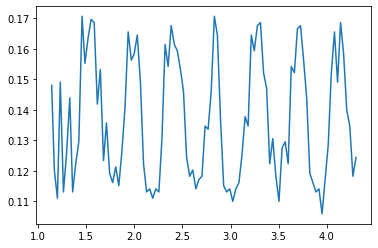

In [7]:
from sensors import TFD, Spindle_Applied
from matplotlib import pyplot as plt

import time
# import logging
# logging.basicConfig(level=logging.DEBUG)

TFD_PORT = '/dev/ttyS26'
SPN_port = '/dev/ttyS33'

TEST_CALIBRATION = 1

def test_tfd():
    tfd = TFD(TFD_PORT)
    max_force = 0
    while True:
        force = tfd.get_force() / TEST_CALIBRATION
        if force > max_force: max_force = force
        print("Force from TFD:", force)
        print("Max force: ", max_force)


def test_spindle():
    start_time = time.perf_counter()
    spindle = Spindle_Applied(SPN_port)
    spindle.set_w(400)
    times, torques = list(), list()
    for i in range(100):
        time.sleep(0.01)
        times.append(time.perf_counter() - start_time)
        torques.append(spindle.get_torque(calibrated = False))
    return times, torques

plt.plot(*test_spindle())

In [6]:
import numpy as np
import time
import shelve
import logging
import queue
# from collect_data import DataPoint, RawDataPacket
from matplotlib import pyplot as plt
from scipy.signal import medfilt


TEST_NAMES = ['6']
results = list()
with shelve.open('results') as db:
    for test_name in TEST_NAMES:
        results += db[test_name]

data_points = list(map(lambda x: x.decompose_packet(), results))


print(data_points[0].W)

x = list(map(lambda x: x.f_r, data_points))
y = list(map(lambda x: x.T, data_points))

plt.figure()
plt.plot(x, y)

KeyError: b'6'

<IPython.core.display.Javascript object>


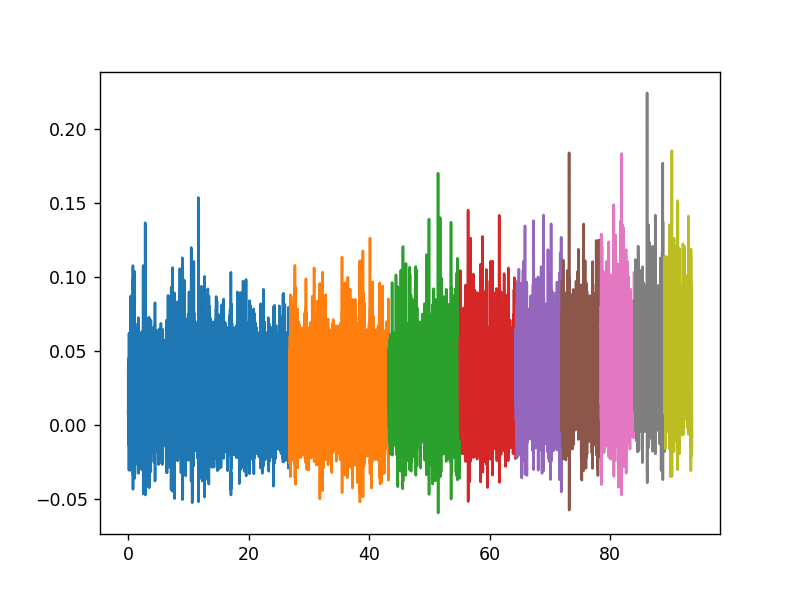

In [2]:
%matplotlib notebook
new_data = list(map(lambda x: RawDataPacket(x.D, x.W, x.R, x.N, x.f_r, x.w, x.measurements), results))
data_points = list(map(lambda x: x.decompose_packet_sorta(), new_data))
plt.figure()
last_time = 0
for tTs, tFys, Ts, Fys in data_points:
    times = [t + last_time for t in tTs]
    stuff = Ts
    filter_size = 3
    fc = int((filter_size + 1) / 2)
    plt.plot(times[fc: -fc], medfilt(stuff, filter_size)[fc: -fc])
    last_time = times[-1]

## Plan
We have three datasets. Two variables are tweaked across dataset. We want to perform some kind of regression to figure out our cutting force coefficients.

Regression is linear if we only vary feed, but becomes nonlinear once we incorporate WOC.

First, maybe just try using a linear regressor for both?

In [12]:
from scipy.optimize import least_squares
def single_residual(d, K_tc, K_te, p):
    return T_exp_lin(d.D, d.N, d.R, d.W, d.f_r, d.w, K_tc, K_te, p) - d.T

def gen_train_pairs():
    X = [[d.D, d.N, d.R, d.W, d.f_r, d.w] for d in data_points]
    y = [d.T for d in data_points]
    return (X, y)

residual_array = np.vectorize(single_residual)

def objective(x):
    K_tc = x[0]
    K_te = x[1]
    p = x[2]
    return residual_array(data_points, K_tc, K_te, p)

class NonLinRegressor:
    
    
    def fit(self, X, Y):
        self.coef = least_squares(lambda coef: [self.evaluate(x, coef) - y for x, y in zip(X, Y)], self.coef).x
        return self
    
    def predict(self, X):
        return [self.evaluate(x, self.coef) for x in X]
    
    def get_params(self, deep=True):
        return {}
    
    def set_params(self, **params):
        ...
    
    def score(self, X, Y):
        u = sum([(y_true - y_pred) ** 2 for y_true, y_pred in zip(Y, self.predict(X))])
        y_true_mean  = np.mean(Y)
        v = sum([(y_true - y_true_mean) ** 2 for y_true in Y])
        return (1 - u/v)
    
class TRegressor(NonLinRegressor):
    def __init__(self):
        self.coef = [0,0,1]
        
    def evaluate(self, x, coef):
        return T_exp_lin(*x, coef[0], coef[1], coef[2])    
        

class FRegressor(NonLinRegressor):
    def __init__(self):
        self.coef = [0,0,0,0, 0, 0]
        
    def evaluate(self, x, coef):
        return F_exp_lin(*x, *coef)[0][1]
    
        
        
estimator = TRegressor()
regressor = RANSACRegressor(base_estimator = estimator, min_samples = 5)

X, y = gen_train_pairs()

# y = [d.Fy * 9.81 ** 2 for d in data_points]

regressor.fit(X, y)
# K_tc, K_te, K_rc, K_re, p, q = regressor.estimator_.coef
K_tc, K_te, p = regressor.estimator_.coef

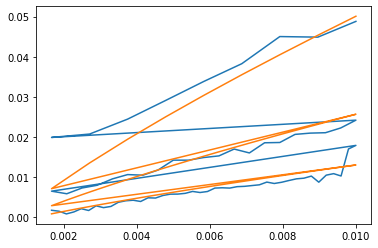

In [13]:
# print(K_tc, K_te, K_rc, K_re, p, q)
y_est = list(map(lambda d : T_exp_lin(d.D, d.N, d.R, d.W, d.f_r, d.w, K_tc, K_te, p), data_points))
# y_est = list(map(lambda d : F_exp_lin(d.D, d.N, d.R, d.W, d.f_r, d.w, K_tc, K_te, K_rc, K_re, p, q), data_points))
# y_est = np.array(y_est)
# y_est = np.squeeze(y_est)[:, 1]
# print(y_est)
plt.figure()
plt.plot(x, y)
plt.plot(x, y_est)

In [5]:
from sklearn.linear_model import RANSACRegressor, LinearRegression
from models import T_x_vector, T_lin, T_exp_lin, calc_h_a, calc_f_t, F_exp_lin

def dataPoint_to_X(d):
    return T_x_vector(d.D, d.N, d.R, d.W, d.f_r, d.w)

def single_residual(d, K_tc, K_te, p):
    return T_exp_lin(d.D, d.N, d.R, d.W, d.f_r, d.w, K_tc, K_te, p) - d.T

residual_array = np.vectorize(single_residual)

def objective(x):
    K_tc = x[0]
    K_te = x[1]
    p = x[2]
    return residual_array(data_points, K_tc, K_te, p)


X = list(map(dataPoint_to_X, data_points))

estimator = LinearRegression(fit_intercept=False)
regressor = RANSACRegressor(base_estimator = estimator)
regressor.fit(X, y)
K_tc, K_te = regressor.estimator_.coef_
print("K_tc = ", K_tc, ", K_te = ", K_te)

x_h_a = np.linspace(0.1e-3, 4e-3, 100)
y_h_a = [calc_h_a(6.35e-3 / 2 , x, calc_f_t(3, 0.0016, 500)) for x in x_h_a]

K_tc =  858494934.9591976 , K_te =  -696.3150933941946


Now we check if we actually fit anything useful

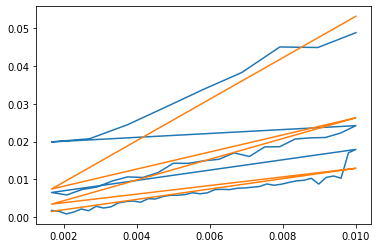

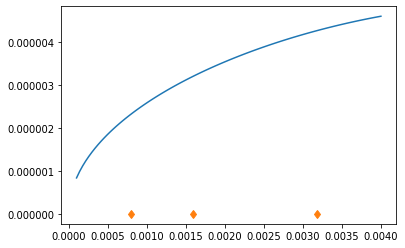

In [138]:
y_est = list(map(lambda d : T_lin(d.D, d.N, d.R, d.W, d.f_r, d.w, K_tc, K_te), data_points))
plt.figure()
plt.plot(x, y)
plt.plot(x, y_est)
plt.figure()
plt.plot(x_h_a, y_h_a)
plt.plot([0.00079375, 0.0015875, 0.003175], [0,0,0], 'd')